In [ ]:
import Pkg
# Pkg.add("SwitchOnSafety")
# Pkg.add("CSDP")
# Pkg.add("JuMP")


# Ejemplo Paper

In [10]:
using SwitchOnSafety
import CSDP

A1 = [0.51 -0.93 0 0 -0.38 ; 1 0 0 0 0 ; 0 1 0 0 0 ; 0 0 1 0 0; 0 0 0 1 0]
A2 = [0.30 0.18 0 0 -0.16 ; 1 0 0 0 0 ; 0 1 0 0 0 ; 0 0 1 0 0; 0 0 0 1 0]
s = discreteswitchedsystem([A1, A2])
optimizer_constructor = optimizer_with_attributes(CSDP.Optimizer, MOI.Silent() => true)
lb, ub = soslyapb(s, 1, optimizer_constructor=optimizer_constructor, tol=1e-6, verbose=1)
seq = sosbuildsequence(s, 1, p_0=:Primal)
psw = findsmp(seq)
lb, ub = soslyapb(s, 2, optimizer_constructor=optimizer_constructor, tol=1e-6, verbose=1)

Lower bound: 1.004620103823135
Upper bound: 1.0046210619039826
Log-diff   : 9.536743163429326e-7 ≤ 1.0e-6
Lower bound: 0.9738404534825906
Upper bound: 0.9738413822096623
Log-diff   : 9.536743164860473e-7 ≤ 1.0e-6


(0.8188989463625622, 0.9738413822096623)

# Aplicación

In [18]:
using SwitchOnSafety
import CSDP
using LinearAlgebra
using Printf
using Statistics

function construir_matriz_companera(phi::Vector{Float64})
    p = length(phi)
    
    if p == 1
        return reshape([phi[1]], 1, 1)
    else
        Phi = zeros(p, p)
        Phi[1, :] = phi
        for i in 2:p
            Phi[i, i-1] = 1.0
        end
        return Phi
    end
end

function calcular_radio_espectral(A::Matrix{Float64})
    eigenvalues = eigvals(A)
    return maximum(abs.(eigenvalues))
end

function analizar_setar(phi_low::Vector{Float64}, phi_high::Vector{Float64}, 
                        gamma::Float64, d::Int; 
                        nombre::String="SETAR", verbose::Bool=true)
    
    # Validar coeficientes
    if isempty(phi_low) || isempty(phi_high)
        error("Los vectores de coeficientes no pueden estar vacíos")
    end
    
    # Determinar el orden del modelo
    p_low = length(phi_low)
    p_high = length(phi_high)
    p = max(p_low, p_high)
    
    # Ajustar vectores al mismo tamaño si es necesario
    if p_low < p
        phi_low = vcat(phi_low, zeros(p - p_low))
    end
    if p_high < p
        phi_high = vcat(phi_high, zeros(p - p_high))
    end
    
    # Construir matrices compañeras
    Phi_low = construir_matriz_companera(phi_low)
    Phi_high = construir_matriz_companera(phi_high)
    
    # Calcular radios espectrales individuales
    rho_low = calcular_radio_espectral(Phi_low)
    rho_high = calcular_radio_espectral(Phi_high)
    
    # Notación del modelo
    m = 2
    modelo_nombre = "SETAR($m; $d, $p)"
    
    if verbose
        println("\n" * "="^70)
        println("$nombre - $modelo_nombre")
        println("="^70)
        println("\nParámetros:")
        println("  φ_low  = $phi_low")
        println("  φ_high = $phi_high")
        println("  γ = $gamma, d = $d, p = $p")
        println("\nRadios espectrales individuales:")
        @printf("  ρ(Φ⁽⁰⁾) = %.6f %s\n", rho_low, rho_low < 1 ? "(< 1, estable)" : "(≥ 1, inestable)")
        @printf("  ρ(Φ⁽¹⁾) = %.6f %s\n", rho_high, rho_high < 1 ? "(< 1, estable)" : "(≥ 1, inestable)")
        
        if rho_low >= 1 || rho_high >= 1
            println("\n  ⚠ Advertencia: Al menos un régimen individual es inestable")
            println("  Esto NO implica necesariamente que el modelo SETAR sea inestable")
        end
    end
    
    # Crear sistema de conmutación discreto
    s = discreteswitchedsystem([Phi_low, Phi_high])
    
    # Configurar optimizador
    optimizer_constructor = optimizer_with_attributes(CSDP.Optimizer, MOI.Silent() => true)
    
    # Variables para almacenar resultados
    lb1, ub1, lb2, ub2 = 0.0, 0.0, 0.0, 0.0
    
    # Para matrices escalares (AR(1)), el JSR es exacto
    if p == 1
        if verbose
            println("\nNota: Para AR(1), JSR = max(|φ_low|, |φ_high|)")
        end
        jsr_exacto = max(rho_low, rho_high)
        lb1 = jsr_exacto
        ub1 = jsr_exacto
        lb2 = jsr_exacto
        ub2 = jsr_exacto
        
        if verbose
            @printf("\nJSR exacto = %.6f\n", jsr_exacto)
        end
    else
        # Para AR(p) con p > 1, usar el algoritmo completo
        if verbose
            println("\nCálculo del Joint Spectral Radius (JSR):")
            println("-"^70)
        end
        
        try
            # ORDEN 1
            if verbose
                println("\n[Orden 1]")
            end
            lb1, ub1 = soslyapb(s, 1, optimizer_constructor=optimizer_constructor, 
                                tol=1e-6, verbose=1)
            
            if verbose
                @printf("Lower bound: %.6f\n", lb1)
                @printf("Upper bound: %.6f\n", ub1)
            end
            
            # Construir secuencia
            seq = sosbuildsequence(s, 1, p_0=:Primal)
            psw = findsmp(seq)
            
            if verbose
                println("\n[Orden 2]")
            end
            
            # ORDEN 2
            lb2, ub2 = soslyapb(s, 2, optimizer_constructor=optimizer_constructor, 
                                tol=1e-6, verbose=1)
            
            if verbose
                @printf("Lower bound: %.6f\n", lb2)
                @printf("Upper bound: %.6f\n", ub2)
            end
            
        catch e
            if verbose
                println("\nAdvertencia: Error en el cálculo SOS.")
                println("Error: ", e)
                println("Usando estimación conservadora...")
            end
            # Estimación conservadora basada en la norma
            norm_low = norm(Phi_low)
            norm_high = norm(Phi_high)
            lb1 = max(rho_low, rho_high)
            ub1 = max(norm_low, norm_high)
            lb2 = lb1
            ub2 = ub1
            
            if verbose
                @printf("\nEstimación: JSR ∈ [%.6f, %.6f]\n", lb2, ub2)
            end
        end
    end
    
    # CRITERIO DE ESTACIONARIEDAD: usar el upper bound (más conservador)
    # Según Teorema 4.4: Si JSR < 1, entonces el proceso es estacionario
    es_estacionario = ub2 < 1.0
    
    # JSR estimado como punto medio del intervalo
    jsr_estimado = (lb2 + ub2) / 2
    
    if verbose
        println("\n" * "="^70)
        println("RESULTADO")
        println("="^70)
        @printf("JSR ∈ [%.6f, %.6f]\n", lb2, ub2)
        @printf("JSR estimado (punto medio) = %.6f\n", jsr_estimado)
        
        println("\nCriterio de estacionariedad: ub2 < 1")
        @printf("Upper bound = %.6f %s\n", ub2, ub2 < 1.0 ? "< 1" : "≥ 1")
        
        if es_estacionario
            println("\n✓ ESTACIONARIO (ub2 < 1)")
            println("\nSegún Teorema 4.4, el proceso es:")
            println("  • Estrictamente estacionario")
            println("  • Ergódico geométricamente")
            println("  • β-mixing con decaimiento geométrico")
        elseif lb2 > 1.0
            println("\n✗ NO ESTACIONARIO (lb2 > 1)")
        else
            println("\n? NO CONCLUYENTE (lb2 ≤ 1 ≤ ub2)")
            println("Se requiere análisis adicional.")
        end
        println("="^70)
    end
    
    # Retornar resultados
    return Dict(
        "nombre" => nombre,
        "modelo" => modelo_nombre,
        "phi_low" => phi_low,
        "phi_high" => phi_high,
        "gamma" => gamma,
        "d" => d,
        "p" => p,
        "rho_low" => rho_low,
        "rho_high" => rho_high,
        "jsr_lb_orden1" => lb1,
        "jsr_ub_orden1" => ub1,
        "jsr_lb_orden2" => lb2,
        "jsr_ub_orden2" => ub2,
        "jsr_estimado" => jsr_estimado,
        "es_estacionario" => es_estacionario
    )
end

function imprimir_resumen(resultados::Vector{Dict})
    println("\n\n" * "="^90)
    println("TABLA RESUMEN COMPARATIVA")
    println("="^90)
    @printf("%-20s %-15s %10s %10s %15s %15s\n", 
            "Nombre", "Modelo", "ρ(Φ⁽⁰⁾)", "ρ(Φ⁽¹⁾)", "JSR", "Estacionario")
    println("-"^90)
    
    for r in resultados
        estacionario_str = r["es_estacionario"] ? "✓ Sí" : "✗ No"
        @printf("%-20s %-15s %10.6f %10.6f %15.6f %15s\n",
                r["nombre"], r["modelo"], 
                r["rho_low"], r["rho_high"], 
                r["jsr_estimado"], estacionario_str)
    end
    println("="^90)
    
    n_estacionarios = sum([r["es_estacionario"] for r in resultados])
    n_total = length(resultados)
    @printf("\nEstacionarios: %d/%d (%.1f%%)\n", 
            n_estacionarios, n_total, 100*n_estacionarios/n_total)
    @printf("JSR promedio: %.6f\n", mean([r["jsr_estimado"] for r in resultados]))
    println("="^90)
end

# ============================================================================
# ANÁLISIS DE MODELOS SETAR
# ============================================================================

println("\n" * "█"^70)
println("ANÁLISIS DE ESTACIONARIEDAD EN MODELOS SETAR")
println("Criterio del Radio Espectral Conjunto (JSR)")
println("█"^70)

resultados = Dict[]

# EJEMPLO BASE: Hansen (1996) - US GNP growth rates
println("\n\n### EJEMPLO BASE: Hansen (1996) - US GNP ###")
r_base = analizar_setar(
    [0.51, -0.93, 0.0, 0.0, -0.38],
    [0.30, 0.18, 0.0, 0.0, -0.16],
    0.01, 2, nombre="Hansen-GNP")
push!(resultados, r_base)

# MODELOS PROPUESTOS
println("\n\n" * "█"^70)
println("MODELOS ADICIONALES")
println("█"^70)

# MODELOS PROPUESTOS - TODOS CON CONFIGURACIONES ÚNICAS
println("\n\n" * "█"^70)
println("MODELOS ADICIONALES - CONFIGURACIONES ÚNICAS")
println("█"^70)

# SETAR(2; 1, 1) - AR(1) con d=1
push!(resultados, analizar_setar([0.6], [-0.5], 0.0, 1, nombre="SETAR-1"))

# SETAR(2; 2, 1) - AR(1) con d=2  
push!(resultados, analizar_setar([0.7], [-0.7], 0.0, 2, nombre="SETAR-2"))

# SETAR(2; 1, 2) - AR(2) con d=1
push!(resultados, analizar_setar([0.5, -0.2], [-0.3, 0.1], 0.5, 1, nombre="SETAR-3"))

# SETAR(2; 2, 2) - AR(2) con d=2
push!(resultados, analizar_setar([0.8, -0.15], [-0.6, 0.2], 1.0, 2, nombre="SETAR-4"))

# SETAR(2; 1, 3) - AR(3) con d=1
push!(resultados, analizar_setar([0.4, -0.1, 0.05], [-0.3, 0.1, -0.05], 0.0, 1, nombre="SETAR-5"))

# SETAR(2; 2, 3) - AR(3) con d=2
push!(resultados, analizar_setar([0.5, -0.3, 0.1], [-0.4, 0.2, -0.05], 0.5, 2, nombre="SETAR-6"))

# SETAR(2; 3, 2) - AR(2) con d=3
push!(resultados, analizar_setar([0.3, 0.1], [-0.2, -0.1], 0.8, 3, nombre="SETAR-7"))

# Tabla resumen final
imprimir_resumen(resultados)


██████████████████████████████████████████████████████████████████████
ANÁLISIS DE ESTACIONARIEDAD EN MODELOS SETAR
Criterio del Radio Espectral Conjunto (JSR)
██████████████████████████████████████████████████████████████████████


### EJEMPLO BASE: Hansen (1996) - US GNP ###

Hansen-GNP - SETAR(2; 2, 5)

Parámetros:
  φ_low  = [0.51, -0.93, 0.0, 0.0, -0.38]
  φ_high = [0.3, 0.18, 0.0, 0.0, -0.16]
  γ = 0.01, d = 2, p = 5

Radios espectrales individuales:
  ρ(Φ⁽⁰⁾) = 0.946200 (< 1, estable)
  ρ(Φ⁽¹⁾) = 0.757716 (< 1, estable)

Cálculo del Joint Spectral Radius (JSR):
----------------------------------------------------------------------

[Orden 1]
Lower bound: 1.004620103823135
Upper bound: 1.0046210619039826
Log-diff   : 9.536743163429326e-7 ≤ 1.0e-6
Lower bound: 0.710374
Upper bound: 1.004621

[Orden 2]
Lower bound: 0.9738404534825906
Upper bound: 0.9738413822096623
Log-diff   : 9.536743164860473e-7 ≤ 1.0e-6
Lower bound: 0.818899
Upper bound: 0.973841

RESULTADO
JSR ∈ [0.818899, 0.

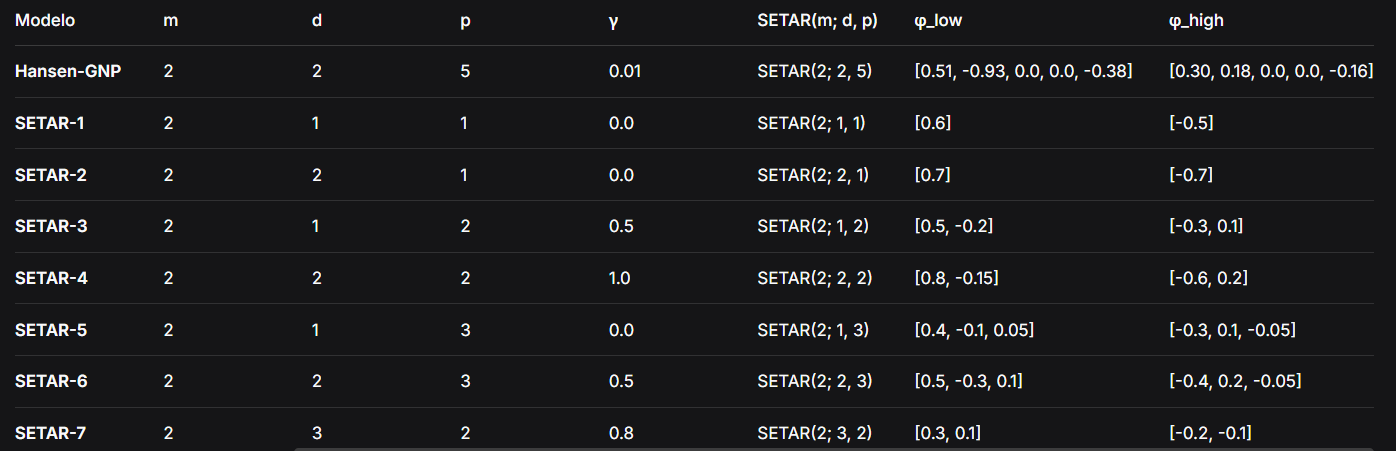